# Segmentation baselines

## Init

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from collections import OrderedDict
from sklearn.preprocessing import MinMaxScaler
import datetime as dt
from scipy import signal
import os

In [2]:
from claspy.data_loader import load_has_dataset
from claspy.segmentation import BinaryClaSPSegmentation

In [3]:
from aeon.segmentation import HidalgoSegmenter, GreedyGaussianSegmenter
from aeon.visualisation.learning_task._segmentation import (
    plot_series_with_change_points,
)
from aeon.visualisation.series._series import plot_series

In [4]:
import ruptures as rpt

In [5]:
from segmentation_utils import (
    extract_eef_data_from_rosbag,
    get_ground_truth_segmentation,
)

In [6]:
# %matplotlib ipympl

## Data files

In [7]:
data_path_root = Path("../table-task-ur5e")
data_path_root.exists()

True

In [8]:
bagfiles = list(data_path_root.glob("*.bag"))
bagfiles

[PosixPath('../table-task-ur5e/rosbag2_2025-08-05_21-08-23_2025-08-05-21-08-23.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-08-05_21-33-31_2025-08-05-21-33-31.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-08-05_21-36-29_2025-08-05-21-36-29.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-08-05_21-43-41_2025-08-05-21-43-41.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-09-04_18-10-23_2025-09-04-18-10-23_test-image.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-09-08_16-33-22_2025-09-08-16-33-23.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-09-08_16-35-57_2025-09-08-16-35-57.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-09-08_16-53-14_2025-09-08-16-53-14_okayish.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-09-08_19-43-25_2025-09-08-19-43-25.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-09-08_19-46-18_2025-09-08-19-46-19.bag')]

In [9]:
filenum = -1
bagfile = bagfiles[filenum]
bagfile

PosixPath('../table-task-ur5e/rosbag2_2025-09-08_19-46-18_2025-09-08-19-46-19.bag')

In [10]:
ground_truth_segm_file = data_path_root / "table_task_UR5e_ground_truth.json"
ground_truth_segm_file.exists()

True

## Preprocessing

In [11]:
traj = extract_eef_data_from_rosbag(bagfile)
traj

Extracting TF & gripper data from Bag file...


  0%|          | 0/183488 [00:00<?, ?it/s]

Extracting TF & gripper data from Bag file: done ✓


,x,y,z,timestamp,gripper
0,-0.057518,-0.349359,0.245916,2025-09-08 18:46:19.430824291-05:00,0.01
1,-0.057527,-0.349371,0.245943,2025-09-08 18:46:19.432620296-05:00,0.01
2,-0.057521,-0.349371,0.245940,2025-09-08 18:46:19.434438816-05:00,0.01
3,-0.057525,-0.349373,0.245945,2025-09-08 18:46:19.436862995-05:00,0.01
4,-0.057515,-0.349382,0.245951,2025-09-08 18:46:19.438580443-05:00,0.01
...,...,...,...,...,...
57561,-0.079063,-0.339990,0.226383,2025-09-08 18:48:14.634462638-05:00,0.01
57562,-0.079040,-0.339984,0.226385,2025-09-08 18:48:14.636379567-05:00,0.01
57563,-0.079073,-0.339983,0.226388,2025-09-08 18:48:14.638744970-05:00,0.01
57564,-0.079063,-0.339978,0.226381,2025-09-08 18:48:14.640788775-05:00,0.01


In [12]:
df = traj.diff().mean().timestamp.total_seconds()
df

0.002001

In [13]:
downsampling = 10

In [14]:
freq = 1 / (df * downsampling)
freq

49.97501249375313

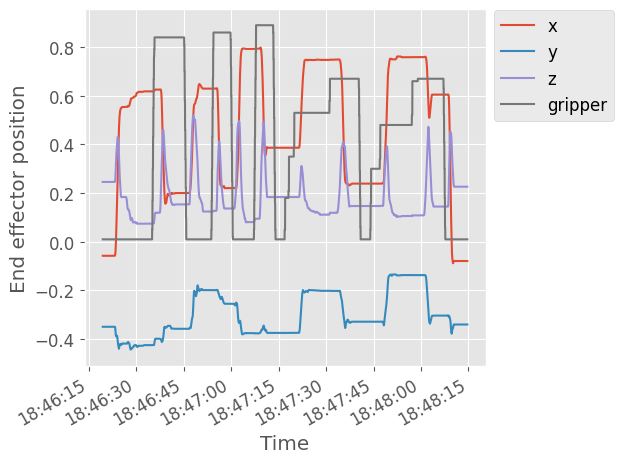

In [15]:
with plt.style.context("ggplot_perso.mplstyle"):
    # with plt.style.context("ggplot"):
    fig, ax = plt.subplots()
    # cmap = mpl.colormaps.get("tab10").colors
    ax.plot(traj.timestamp, traj.x, label="x")  # , color=cmap[0])
    ax.plot(traj.timestamp, traj.y, label="y")  # , color=cmap[1])
    ax.plot(traj.timestamp, traj.z, label="z")  # , color=cmap[2])
    ax.plot(traj.timestamp, traj.gripper, label="gripper")  # , color=cmap[3])
    ax.set_xlabel("Time")
    ax.set_ylabel("End effector position")
    # ax.legend(loc="best")
    ax.legend(bbox_to_anchor=(1.0, 1.02))
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()

## Ground truth segmentation

In [16]:
gt_segm_dict = get_ground_truth_segmentation(
    ground_truth_segm_file=ground_truth_segm_file, bagfile=bagfile
)
gt_segm_dict

{'filename': 'rosbag2_2025-09-08_19-46-18_2025-09-08-19-46-19.bag',
 'HigherLevel': {'plate': {'ini': 1757375183, 'end': 1757375205},
  'cup': {'ini': 1757375207, 'end': 1757375220},
  'napkin': {'ini': 1757375220, 'end': 1757375232},
  'spoon': {'ini': 1757375235, 'end': 1757375258},
  'fork': {'ini': 1757375262, 'end': 1757375288}},
 'LowerLevel': {'reaching': [{'ini': 1757375183, 'end': 1757375194},
   {'ini': 1757375207, 'end': 1757375212},
   {'ini': 1757375220, 'end': 1757375226},
   {'ini': 1757375235, 'end': 1757375253},
   {'ini': 1757375262, 'end': 1757375280}],
  'placing': [{'ini': 1757375197, 'end': 1757375205},
   {'ini': 1757375215, 'end': 1757375220},
   {'ini': 1757375228, 'end': 1757375232},
   {'ini': 1757375253, 'end': 1757375258},
   {'ini': 1757375280, 'end': 1757375288}]}}

### Higher level movements

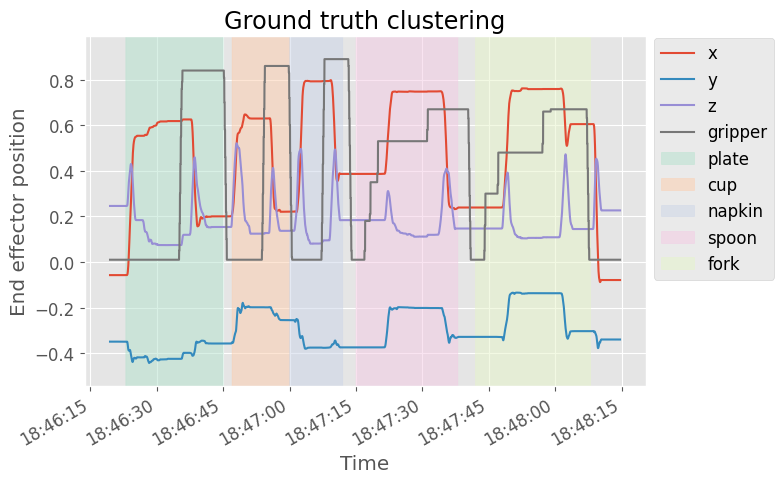

In [17]:
with plt.style.context("ggplot_perso.mplstyle"):
    fig, ax = plt.subplots(figsize=(8, 5))
    cmap = mpl.colormaps.get("Pastel2").colors
    ax.plot(traj.timestamp, traj.x, label="x")  # , color=cmap[0])
    ax.plot(traj.timestamp, traj.y, label="y")  # , color=cmap[1])
    ax.plot(traj.timestamp, traj.z, label="z")  # , color=cmap[2])
    ax.plot(traj.timestamp, traj.gripper, label="gripper")  # , color=cmap[3])

    fill_min = np.min([traj.x.min(), traj.y.min(), traj.z.min(), traj.gripper.min()])
    fill_max = np.max([traj.x.max(), traj.y.max(), traj.z.max(), traj.gripper.max()])
    for sect_i, sect_key in enumerate(gt_segm_dict["HigherLevel"].keys()):
        sect_dict_current = gt_segm_dict["HigherLevel"][sect_key]
        xs = traj.timestamp[
            (
                traj.timestamp
                > pd.Timestamp(
                    dt.datetime.fromtimestamp(sect_dict_current["ini"])
                    - dt.timedelta(hours=1),
                    tz="EST",
                )
            )
            & (
                traj.timestamp
                < pd.Timestamp(
                    dt.datetime.fromtimestamp(sect_dict_current["end"])
                    - dt.timedelta(hours=1),
                    tz="EST",
                )
            )
        ]  # - dt.timedelta(hours=5)
        ax.fill_between(
            x=xs,
            y1=fill_min - 1,
            y2=fill_max + 1,
            color=cmap[sect_i],
            alpha=0.5,
            transform=ax.get_xaxis_transform(),
            label=sect_key,
        )

    ax.set_ylim(bottom=fill_min - 0.1, top=fill_max + 0.1)
    ax.set_xlabel("Time")
    ax.set_ylabel("End effector position")
    ax.legend(bbox_to_anchor=(1.0, 1.02))
    ax.set_title("Ground truth clustering")
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()

### Lower level movements

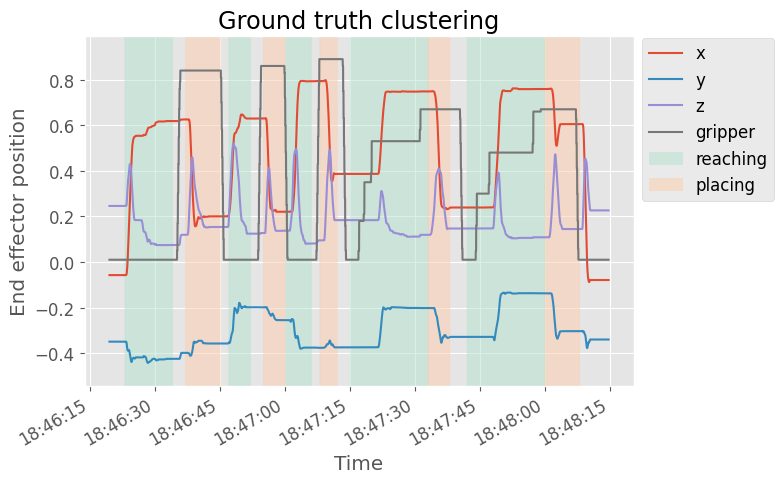

In [18]:
with plt.style.context("ggplot_perso.mplstyle"):
    fig, ax = plt.subplots(figsize=(8, 5))
    cmap = mpl.colormaps.get("Pastel2").colors
    ax.plot(traj.timestamp, traj.x, label="x")  # , color=cmap[0])
    ax.plot(traj.timestamp, traj.y, label="y")  # , color=cmap[1])
    ax.plot(traj.timestamp, traj.z, label="z")  # , color=cmap[2])
    ax.plot(traj.timestamp, traj.gripper, label="gripper")  # , color=cmap[3])

    fill_min = np.min([traj.x.min(), traj.y.min(), traj.z.min(), traj.gripper.min()])
    fill_max = np.max([traj.x.max(), traj.y.max(), traj.z.max(), traj.gripper.max()])
    for sect_i, sect_key in enumerate(gt_segm_dict["LowerLevel"].keys()):
        skill_current = gt_segm_dict["LowerLevel"][sect_key]
        for skill_i, skill_val in enumerate(skill_current):
            xs = traj.timestamp[
                (
                    traj.timestamp
                    > pd.Timestamp(
                        dt.datetime.fromtimestamp(skill_val["ini"])
                        - dt.timedelta(hours=1),
                        tz="EST",
                    )
                )
                & (
                    traj.timestamp
                    < pd.Timestamp(
                        dt.datetime.fromtimestamp(skill_val["end"])
                        - dt.timedelta(hours=1),
                        tz="EST",
                    )
                )
            ]  # - dt.timedelta(hours=5)
            if skill_i == 0:
                ax.fill_between(
                    x=xs,
                    y1=fill_min - 1,
                    y2=fill_max + 1,
                    color=cmap[sect_i],
                    alpha=0.5,
                    transform=ax.get_xaxis_transform(),
                    label=sect_key,
                )
            else:
                ax.fill_between(
                    x=xs,
                    y1=fill_min - 1,
                    y2=fill_max + 1,
                    color=cmap[sect_i],
                    alpha=0.5,
                    transform=ax.get_xaxis_transform(),
                    # label=sect_key,
                )

    ax.set_ylim(bottom=fill_min - 0.1, top=fill_max + 0.1)
    ax.set_xlabel("Time")
    ax.set_ylabel("End effector position")
    ax.legend(bbox_to_anchor=(1.0, 1.02))
    ax.set_title("Ground truth clustering")
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()

## Segmentation

In [19]:
true_cps = np.ones((len(gt_segm_dict["HigherLevel"]) - 1)) * np.nan
for sect_i, sect_key in enumerate(gt_segm_dict["HigherLevel"].keys()):
    sect_dict_current = gt_segm_dict["HigherLevel"][sect_key]
    if sect_i < len(true_cps):
        true_cps[sect_i] = sect_dict_current["end"]
true_cps

array([1.75737520e+09, 1.75737522e+09, 1.75737523e+09, 1.75737526e+09])

In [20]:
labels = gt_segm_dict["HigherLevel"].keys()
labels

dict_keys(['plate', 'cup', 'napkin', 'spoon', 'fork'])

In [21]:
X = traj.drop(columns=["timestamp"])
X

,x,y,z,gripper
0,-0.057518,-0.349359,0.245916,0.01
1,-0.057527,-0.349371,0.245943,0.01
2,-0.057521,-0.349371,0.245940,0.01
3,-0.057525,-0.349373,0.245945,0.01
4,-0.057515,-0.349382,0.245951,0.01
...,...,...,...,...
57561,-0.079063,-0.339990,0.226383,0.01
57562,-0.079040,-0.339984,0.226385,0.01
57563,-0.079073,-0.339983,0.226388,0.01
57564,-0.079063,-0.339978,0.226381,0.01


In [22]:
X_scaled = MinMaxScaler(feature_range=(0, 1)).fit_transform(X)
X_scaled

array([[0.03466634, 0.30298799, 0.38457212, 0.        ],
       [0.03465621, 0.30295002, 0.38463162, 0.        ],
       [0.03466358, 0.30294936, 0.38462524, 0.        ],
       ...,
       [0.01035104, 0.3333613 , 0.3408574 , 0.        ],
       [0.01036216, 0.33337666, 0.34084089, 0.        ],
       [0.01035894, 0.33336528, 0.34081912, 0.        ]], shape=(57566, 4))

In [23]:
downsampling_factor = 10
X_down = signal.decimate(x=X, q=downsampling_factor, axis=0)
X_down

array([[-0.05685907, -0.34535993,  0.24310149,  0.00988553],
       [-0.05686354, -0.34537592,  0.24312374,  0.00988553],
       [-0.05686813, -0.34537414,  0.24311757,  0.00988553],
       ...,
       [-0.07815416, -0.33608224,  0.22377514,  0.00988553],
       [-0.07815445, -0.33608737,  0.22377973,  0.00988553],
       [-0.07815985, -0.33609272,  0.22378373,  0.00988553]],
      shape=(5757, 4))

In [24]:
minmaxscaler = MinMaxScaler(feature_range=(0, 1))
X_down_scaled = minmaxscaler.fit_transform(X_down)
X_down_scaled

array([[0.03468915, 0.30297847, 0.38453166, 0.01339656],
       [0.03468405, 0.30292607, 0.38458204, 0.01339656],
       [0.03467881, 0.3029319 , 0.38456808, 0.01339656],
       ...,
       [0.01038961, 0.33338659, 0.34076122, 0.01339656],
       [0.01038928, 0.33336977, 0.34077161, 0.01339656],
       [0.01038312, 0.33335225, 0.34078069, 0.01339656]], shape=(5757, 4))

### Multivariate ClaSP

In [25]:
# dominant_period_size = find_dominant_window_sizes(X_scaled[:, 0])
# print("Dominant Period", dominant_period_size)

In [26]:
clasp = BinaryClaSPSegmentation(
    n_segments=len(labels), n_jobs=os.cpu_count() - 1
)  # , window_size=dominant_period_size)

In [27]:
# pred = clasp.fit_predict(X_scaled)
pred = clasp.fit_predict(X_down_scaled)
pred

array([], dtype=float64)

In [28]:
if pred.size == 0:
    print("No segmentation classes found...")
else:
    clasp.plot(
        gt_cps=true_cps,
        heading=f"Segmentation of activity routine: {', '.join(labels)}",
        ts_name="ACC",
        font_size=18,
        file_path="test-multivariate-ClaSP.png",
    )

No segmentation classes found...


In [29]:
# _ = plot_series_with_profiles(
#     X_scaled,
#     clasp.profiles,
#     true_cps=true_cps,
#     found_cps=found_cps,
#     title="ClaSP segmentation",
# )

### Hidalgo

In [30]:
hidalgo = HidalgoSegmenter(K=len(labels), q=3, n_iter=2000, burn_in=0.8)

In [31]:
try:
    cps = hidalgo.fit_predict(X_scaled, axis=0)
    print("Found change points:", cps)
except AssertionError as ae:
    print("\nAssertion error bug...")

/home/kir0ul/Projects/segmentation-utils/.venv/lib64/python3.11/site-packages/aeon/segmentation/_hidalgo.py:173: RuntimeWarning: divide by zero encountered in divide
  mu = np.divide(distances[:, 2], distances[:, 1])



Assertion error bug...


### GGS

In [32]:
ggs = GreedyGaussianSegmenter(k_max=len(labels), lamb=1, verbose=True)

In [33]:
cps = ggs.fit_predict(X_down_scaled, axis=0)
cps

array([0, 0, 0, ..., 5, 5, 5], shape=(5757,), dtype=int32)

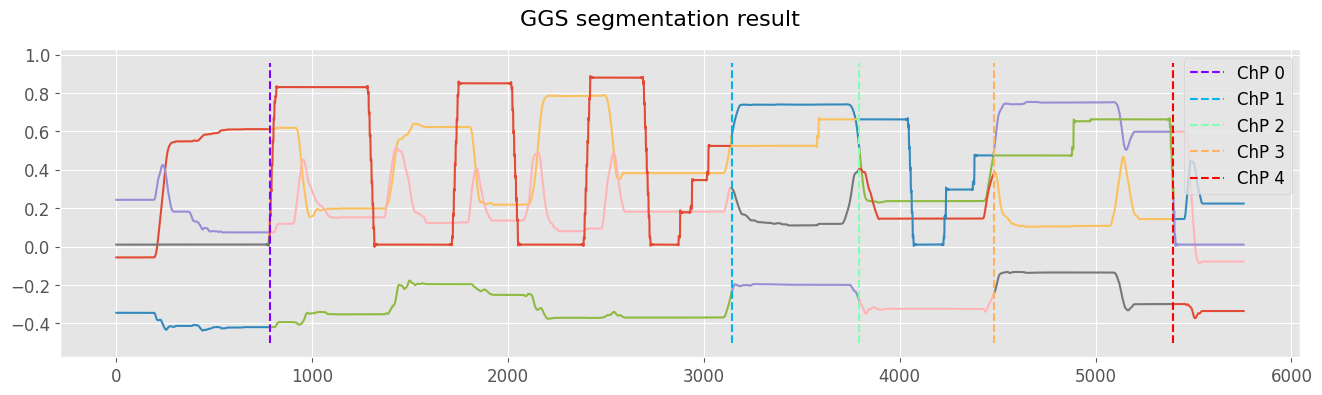

In [34]:
with plt.style.context("ggplot_perso.mplstyle"):
    fig, ax = plot_series_with_change_points(
        y=X_down,
        change_points=np.where(np.diff(cps) != 0)[0],
        title="GGS segmentation result",
        font_size=16,
    )
    plt.show()

### ruptures

In [35]:
# # Higher level change points
# penalty = 125
# bkps_iso = [segm["end"] for segm in gt_segm_dict["HigherLevel"].values()]
# bkps_iso

In [36]:
# Lower level change points
penalty = 90
bkps_iso = []
for skill in gt_segm_dict["LowerLevel"].values():
    for segm in skill:
        bkps_iso.append(segm["end"])
bkps_iso

[1757375194,
 1757375212,
 1757375226,
 1757375253,
 1757375280,
 1757375205,
 1757375220,
 1757375232,
 1757375258,
 1757375288]

In [37]:
bkps = np.empty_like(bkps_iso) * np.nan
bkps

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [38]:
for idx in range(len(bkps)):
    bkps[idx] = traj[
        traj.timestamp
        >= pd.Timestamp(
            dt.datetime.fromtimestamp(bkps_iso[idx]) - dt.timedelta(hours=1),
            tz="EST",
        )
    ].index[0]
bkps

array([ 7281., 16272., 23269., 36758., 50250., 12773., 20271., 26266.,
       39256., 54246.])

In [39]:
# detection
algo = rpt.Pelt(model="rbf").fit(X_down_scaled)
# algo = rpt.KernelCPD(kernel="rbf").fit(X_down_scaled)
# algo = rpt.KernelCPD(kernel="cosine").fit(X_scaled)
result = algo.predict(pen=penalty)
print(result)

[255, 800, 1305, 1730, 2040, 2405, 2705, 3130, 3790, 4495, 5120, 5475, 5757]


In [40]:
# algo = rpt.Dynp(model="rbf").fit(X_down_scaled)
# result = algo.predict(n_bkps=len(labels)-1)
# print(result)

In [41]:
# signal, bkps = rpt.pw_constant(n_samples, n_dims, n_bkps, noise_std=sigma)

In [42]:
# # display
# with plt.style.context("ggplot_perso.mplstyle"):
#     rpt.display(X_scaled, bkps, result)
#     plt.show()

In [43]:
# minmaxscaler.inverse_transform(X_down_scaled)

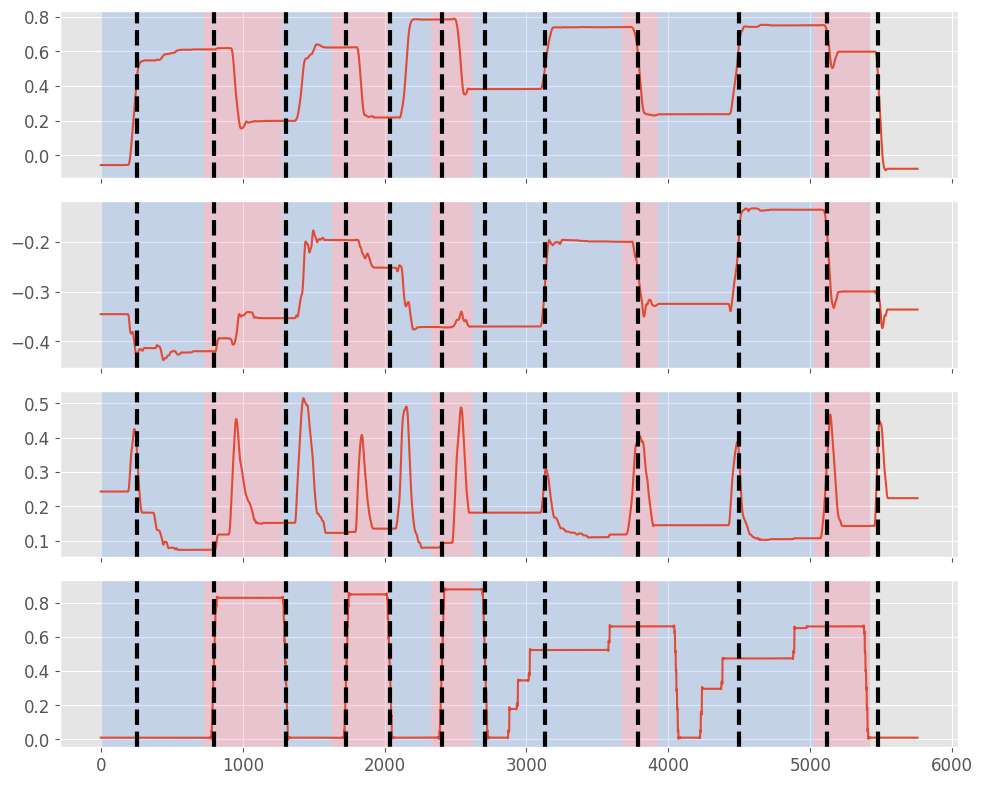

In [44]:
# display
with plt.style.context("ggplot_perso.mplstyle"):
    # rpt.display(minmaxscaler.inverse_transform(X_down_scaled), bkps, result)
    rpt.display(X_down, bkps / downsampling_factor, result)
    plt.show()